# Consumer Complaints – Exploratory NLP Analysis

## 1. Project Overview

The objective of this project is to perform an exploratory analysis of **consumer complaint narratives** using Natural Language Processing (NLP) techniques. The analysis focuses on understanding the structure, volume, and textual characteristics of complaints submitted by consumers.

This notebook demonstrates data cleaning, text preprocessing, and initial NLP exploration steps that are commonly required in real-world analytics and data science projects.

---

## 2. Dataset Description

The dataset contains records of consumer complaints submitted to companies. Each row represents a complaint and includes metadata such as dates, product information, and a free-text narrative written by the consumer.

---

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 


In [2]:
df= pd.read_csv('consumer_complaints.csv')
print(df.info())

C:\Users\bertr\AppData\Local\Temp\ipykernel_20420\3877813296.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('consumer_complaints.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [3]:
df['date']=pd.to_datetime(df['date_received'])

In [4]:
df['date_sent']=pd.to_datetime(df['date_sent_to_company'])

## Missing Value Handling

In [5]:
complaints_text = df['consumer_complaint_narrative']
complaints_text_clean = complaints_text.dropna()

### Consumer complaint narratives with missing values were removed to ensure that downstream NLP processing is applied only to valid textual data.

## 2) Regex tokenization (Basic cleaning to remove extra spaces/newlines)

In [6]:
import re

In [7]:
example = complaints_text_clean[190126]

In [8]:
example_clean= re.sub(r"\s+", " ", example).strip()
print(example_clean)

XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! They continue to insist I owe them and collection agencies are after me. How can I stop this harassment for a bill I already paid four years ago?


## 3) Tokenize + lower case

In [9]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")

tokens = word_tokenize(example_clean)
tokens = [t.lower() for t in tokens]
print(tokens[:40])


['xxxx', 'has', 'claimed', 'i', 'owe', 'them', '{', '$', '27.00', '}', 'for', 'xxxx', 'years', 'despite', 'the', 'proof', 'of', 'payment', 'i', 'sent', 'them', ':', 'canceled', 'check', 'and', 'their', 'ownpaid', 'invoice', 'for', '{', '$', '27.00', '}', '!', 'they', 'continue', 'to', 'insist', 'i', 'owe']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bertr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bertr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 4) Remove punctuation + stopwords

In [10]:
import string
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

tokens_nopunct = [t for t in tokens if t not in string.punctuation]
tokens_clean = [t for t in tokens_nopunct if t not in stop_words]

print(tokens_clean)


['xxxx', 'claimed', 'owe', '27.00', 'xxxx', 'years', 'despite', 'proof', 'payment', 'sent', 'canceled', 'check', 'ownpaid', 'invoice', '27.00', 'continue', 'insist', 'owe', 'collection', 'agencies', 'stop', 'harassment', 'bill', 'already', 'paid', 'four', 'years', 'ago']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bertr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 5) Normalize patterns you care about (money, masked names)

In [11]:
def normalize_tokens(tokens):
    out = []
    for t in tokens:
        # normalize money (e.g. 27.00, $27.00)
        if re.fullmatch(r"\$?\d+(\.\d+)?", t):
            out.append("<money>")
        # normalize masked names
        elif t == "xxxx":
            out.append("<masked>")
        else:
            out.append(t)
    return out

tokens_norm = normalize_tokens(tokens_clean)
print(tokens_norm)


['<masked>', 'claimed', 'owe', '<money>', '<masked>', 'years', 'despite', 'proof', 'payment', 'sent', 'canceled', 'check', 'ownpaid', 'invoice', '<money>', 'continue', 'insist', 'owe', 'collection', 'agencies', 'stop', 'harassment', 'bill', 'already', 'paid', 'four', 'years', 'ago']


## 6) Simple descriptive stats (quick insights)

In [12]:
from collections import Counter

freq = Counter(tokens_norm)
print("Top tokens:", freq.most_common(10))
print("Total tokens:", len(tokens_norm))
print("Unique tokens:", len(freq))


Top tokens: [('<masked>', 2), ('owe', 2), ('<money>', 2), ('years', 2), ('claimed', 1), ('despite', 1), ('proof', 1), ('payment', 1), ('sent', 1), ('canceled', 1)]
Total tokens: 28
Unique tokens: 24


In [13]:
punctuation = set(string.punctuation)

## Define the normalization function (once) to apply it to the whole column 

In [14]:
def normalize_text(text):
    tokens = word_tokenize(str(text).lower())

    cleaned_tokens = []
    for t in tokens:
        # normalize money
        if re.fullmatch(r"\$?\d+(\.\d+)?", t):
            cleaned_tokens.append("<money>")
        # normalize masked names
        elif t == "xxxx":
            cleaned_tokens.append("<masked>")
        # remove stopwords & punctuation
        elif t in stop_words or t in punctuation:
            continue
        else:
            cleaned_tokens.append(t)

    return cleaned_tokens

In [15]:
complaints_text_clean_tokens = complaints_text_clean.apply(normalize_text)

In [16]:
complaints_text_clean_tokens

190126    [<masked>, claimed, owe, <money>, <masked>, ye...
190135    [due, inconsistencies, amount, owed, told, ban...
190155    [xx/xx/xxxx, wages, earned, job, decreased, al...
190207    [open, current, mortgage, chase, bank, <masked...
190208    [<masked>, submitted, xx/xx/xxxx, time, submit...
                                ...                        
553084    [<masked>, <masked>, reporting, incorrectly, p...
553085       [reflecting, incorrect, payment, status, time]
553086    [paying, <money>, month, direct, debit, withdr...
553090    [recently, became, aware, amerisave, mortgage,...
553096    [bank, america, demonstrated, on-going, level,...
Name: consumer_complaint_narrative, Length: 66806, dtype: object

##  Total number of documents

In [17]:
num_docs = len(complaints_text_clean_tokens)
print("Number of documents:", num_docs)


Number of documents: 66806


## 2️) Describe analysis Token per document

In [18]:
token_count_per_doc = complaints_text_clean_tokens.apply(len)

token_count_per_doc.describe()


count    66806.000000
mean        95.892944
std         84.407444
min          0.000000
25%         36.000000
50%         68.000000
75%        127.000000
max       1267.000000
Name: consumer_complaint_narrative, dtype: float64

## 3️) Flatten all tokens (CRITICAL step)
To analyse the whole corpus, the column must be flatten. 

In [19]:
from itertools import chain

all_tokens = list(chain.from_iterable(complaints_text_clean_tokens))


## 4) Vocabulary size (unique words)

In [20]:
vocab_size = len(set(all_tokens))
print("Vocabulary size:", vocab_size)


Vocabulary size: 73585


## 5) Most common BIGRAMS (very useful for complaints)

In [21]:
from nltk.util import ngrams

bigrams = list(ngrams(all_tokens, 2))
top_bigrams = Counter(bigrams).most_common(30)

## biagram bar chart

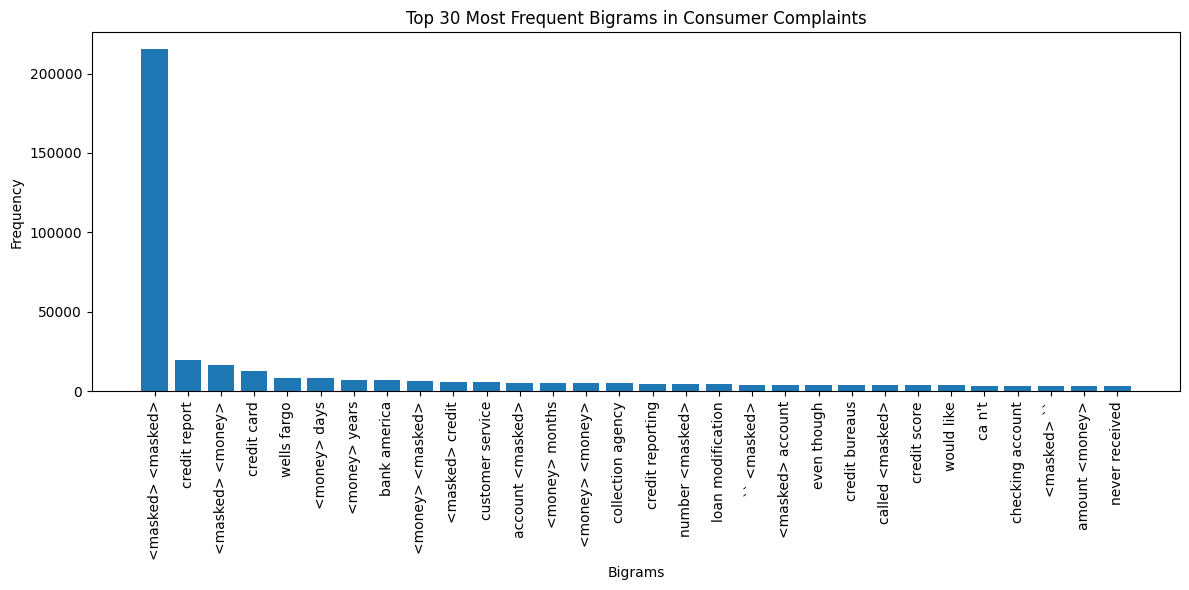

In [22]:
# Separate bigrams and counts
bigram_labels = [' '.join(bigram) for bigram, count in top_bigrams]
bigram_counts = [count for bigram, count in top_bigrams]
plt.figure(figsize=(12, 6))
plt.bar(bigram_labels, bigram_counts)
plt.xticks(rotation=90)
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Top 30 Most Frequent Bigrams in Consumer Complaints")
plt.tight_layout()
plt.show()

### 🔍 Key insights from the Bigram Frequency Chart

### 1️⃣ Data masking dominates the narratives

The most frequent bigram by a **very large margin** is:

* **`<masked> <masked>`**
* Followed by **`<masked> money`**, **`money <masked>`**, etc.

### Insight

This indicates that:

* The dataset contains **heavy anonymisation** (names, account numbers, sensitive fields).
* Consumers often refer to **personal or financial details** that are systematically masked.

📌 **Analytical implication:**
Any downstream NLP modelling (e.g. topic modelling) must account for masking tokens, as they can dominate frequency-based methods.

---

### 2️⃣ Credit reporting and credit score issues are a core theme

Highly frequent bigrams include:

* **credit report**
* **credit score**
* **credit card**
* **credit bureaus**
* **collection agency**
* **credit reporting**

### Insight

A significant portion of complaints relates to:

* Credit report inaccuracies
* Credit score disputes
* Collections and reporting agencies

📌 **Business interpretation:**
Credit reporting disputes appear to be one of the **primary drivers of consumer dissatisfaction**, suggesting regulatory, compliance, or data accuracy issues.

---

### 3️⃣ Financial institutions and products are central to complaints

Notable bigrams:

* **wells fargo**
* **bank america**
* **checking account**
* **loan modification**
* **credit card**

### Insight

Consumers frequently mention:

* Specific **banks**
* Core **financial products** (loans, checking accounts, cards)

📌 **Business interpretation:**
Complaints are not abstract — they are tied to **specific institutions and products**, making this dataset well-suited for:

* Institution-level analysis
* Product-level complaint segmentation

---

### 4️⃣ Money, time, and unresolved issues recur together

Repeated time- and money-related bigrams:

* **money days**
* **money years**
* **never received**
* **even though**
* **would like**
* **can’t**

### Insight

These phrases reflect:

* Long-running disputes
* Delays in resolution
* Consumer frustration over **unresolved financial issues**

📌 **Customer experience signal:**
Complaints often escalate not just because of financial loss, but due to **duration and lack of resolution**.

---

### 5️⃣ Complaints often involve third parties

Frequent mentions of:

* **credit bureaus**
* **collection agency**
* **customer service**

### Insight

Many complaints involve **multi-party interactions**, where:

* Responsibility is unclear
* Resolution is delayed
* Consumers feel “passed around”

📌 **Operational insight:**
This suggests process breakdowns between institutions, service teams, and reporting agencies.

---

## 🧠 Conclusion

> Bigram analysis reveals that consumer complaints are heavily concentrated around credit reporting, financial products, and unresolved monetary disputes. The prevalence of time-related phrases and third-party entities highlights systemic issues in complaint resolution processes rather than isolated transactional errors.

---

## 6) Percentage of complaints mentioning money

In [23]:
money_rate = sum(
    "<money>" in tokens for tokens in complaints_text_clean_tokens
) / num_docs

print(f"Complaints mentioning money: {money_rate:.2%}")


Complaints mentioning money: 55.40%


## 7) Summary dashboard (quick insight block)

In [24]:
summary = pd.DataFrame({
    "documents": [num_docs],
    "avg_tokens": [token_count_per_doc.mean()],
    "median_tokens": [token_count_per_doc.median()],
    "vocab_size": [len(set(all_tokens))],
    "money_rate": [money_rate]
})
print(summary)

   documents  avg_tokens  median_tokens  vocab_size  money_rate
0      66806   95.892944           68.0       73585    0.553977


In [25]:
df4 = complaints_text_clean[complaints_text_clean.str.contains(r"\bbank america\b", case=False, na=False)]

In [26]:
df4

197127    To whom it may concern : I submitted and compl...
199616    Complaint : XXXX Credit Union and Bank of Amer...
203118    bank of America has a atm suspicious activity ...
203723    I have XXXX credit cards with Bank America. Ho...
208907    I am XXXX years old female who hold a conventi...
210566    RE : Additional Fees in amount $ 250.00Time an...
211483    I have XXXX checking and XXXX credit card acco...
217749    XXXX XXXX, XXXXIn XX/XX/XXXX we purchased a ma...
223533    Bank America is insisting a home buyer obtain ...
235953    hi, my mortgage was with countrywide until XXX...
240201    XX/XX/2012, my husband was getting ready to re...
240715    my name is XXXX XXXX, my business address is X...
242944    My name is XXXX XXXX. I am now XXXX and retire...
249041    At XX/XX/XXXX, I had a buyer for our RV and be...
254738    I have a loan mod with bank America/ XXXX they...
255236    From XXXX I have mortgages loans with Bank Of ...
261195    i refinanced my mortgage on XX

In [27]:
df4[197127]

"To whom it may concern : I submitted and complainant on the XXXX/XXXX/2014 : on the letter that yawl send me stated that some complaint. if so something should be done about the same complaint over and should let you know over so that so that should let you know that there is some truth to this matter and I gave the only info that I had. The info that Lawyer gave was Ford and forgery and I do not have A Business on XXXX or any or any ware else. what they are say is I have Company business in my home when I do n't have one so now they base my payment on something that the lawyer say but he is lying about the no business here there was never an business here. was documents that give the Bank America from this Lawyer. \n"

In [28]:
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'date',
       'date_sent'],
      dtype='object')

In [29]:
df.loc[197127]

date_received                                                          03/20/2015
product                                                                  Mortgage
sub_product                                           Conventional fixed mortgage
issue                                    Application, originator, mortgage broker
sub_issue                                                                     NaN
consumer_complaint_narrative    To whom it may concern : I submitted and compl...
company_public_response          Company chooses not to provide a public response
company                                                           Bank of America
state                                                                          FL
zipcode                                                                     333XX
tags                                                                          NaN
consumer_consent_provided                                        Consent provided
submitted_via   